In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as tsg
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime, date

In [2]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0)

df = df_raw[['Date', 'Lake_Level']].copy()
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

df.set_index(['Date'], inplace=True)
df = df.asfreq('D')
print(df.index)


# df = df.resample('W').mean()
# df = df.asfreq('W')
df.head(5)

DatetimeIndex(['2002-06-03', '2002-06-04', '2002-06-05', '2002-06-06',
               '2002-06-07', '2002-06-08', '2002-06-09', '2002-06-10',
               '2002-06-11', '2002-06-12',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=6603, freq='D')


,Lake_Level
Date,
2002-06-03,249.43
2002-06-04,249.43
2002-06-05,249.43
2002-06-06,249.43
2002-06-07,249.44


In [3]:
df['Lake_Level'] -= (251 - 31)
print(df.isna().sum())

Lake_Level    0
dtype: int64


<AxesSubplot:xlabel='Date'>

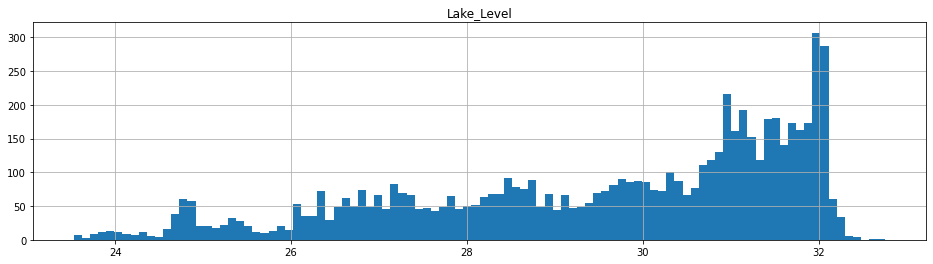

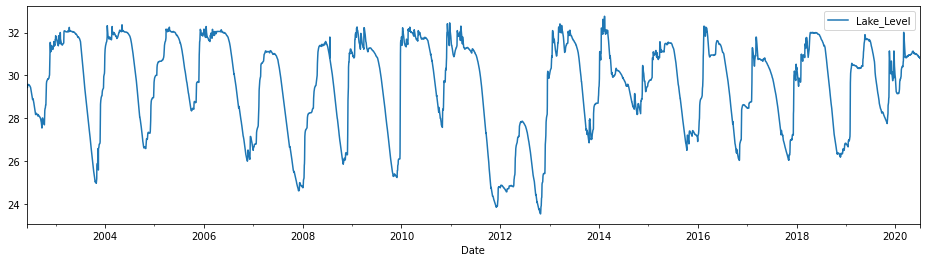

In [4]:
df.hist(figsize=(16, 4), bins=100)
df.plot(figsize=(16, 4))

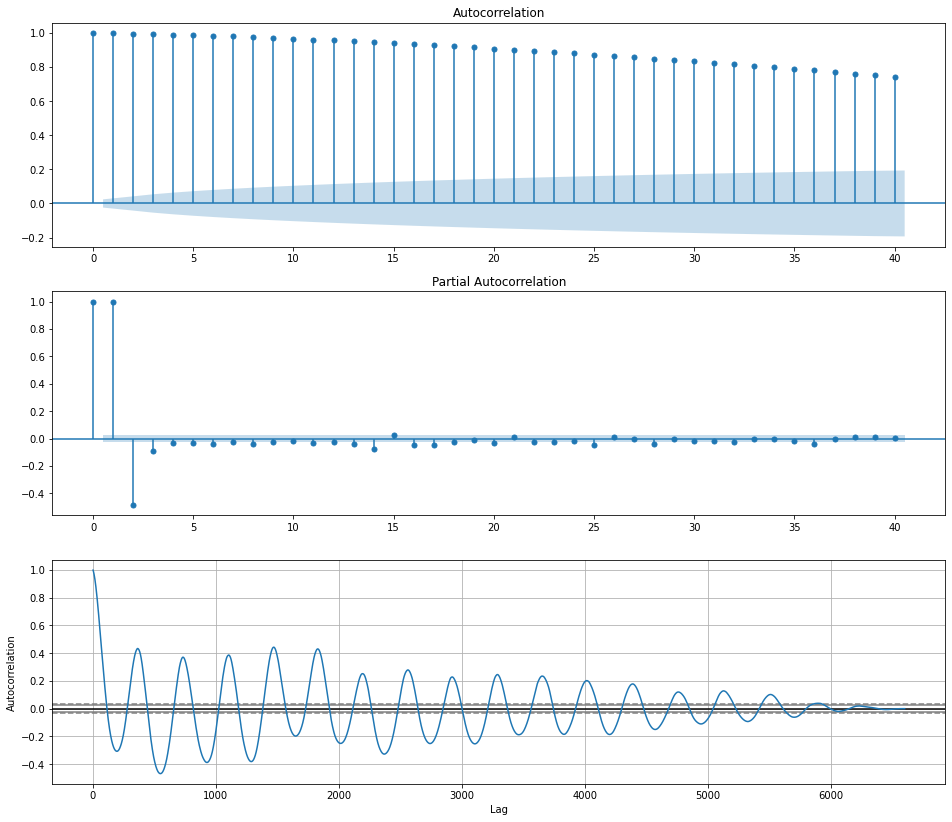

In [5]:
# SEASONALITY CHECK
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(3, 1, figsize=(16, 14))

tsg.plot_acf(df['Lake_Level'],lags=40, ax=ax[0])
tsg.plot_pacf(df['Lake_Level'],lags=40, ax=ax[1])
autocorrelation_plot(df['Lake_Level'], ax=ax[2])

plt.show()

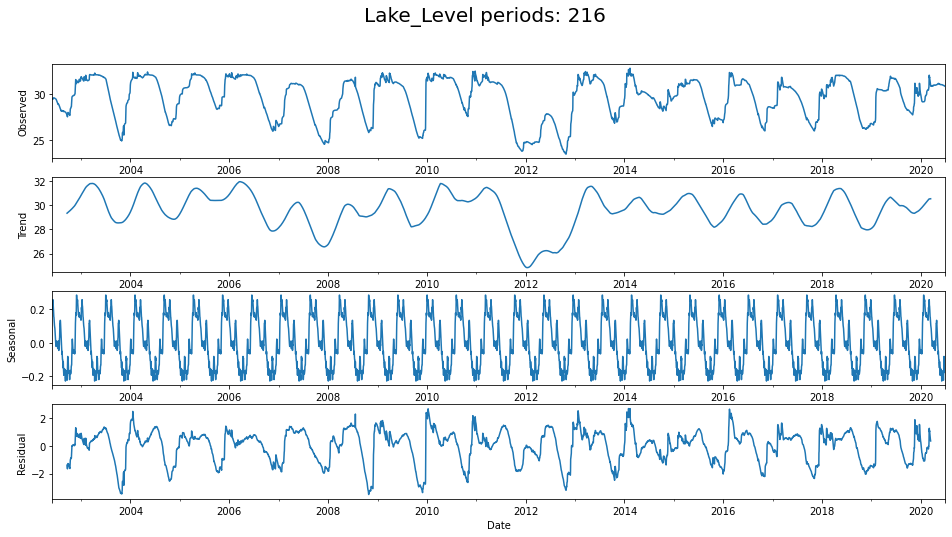

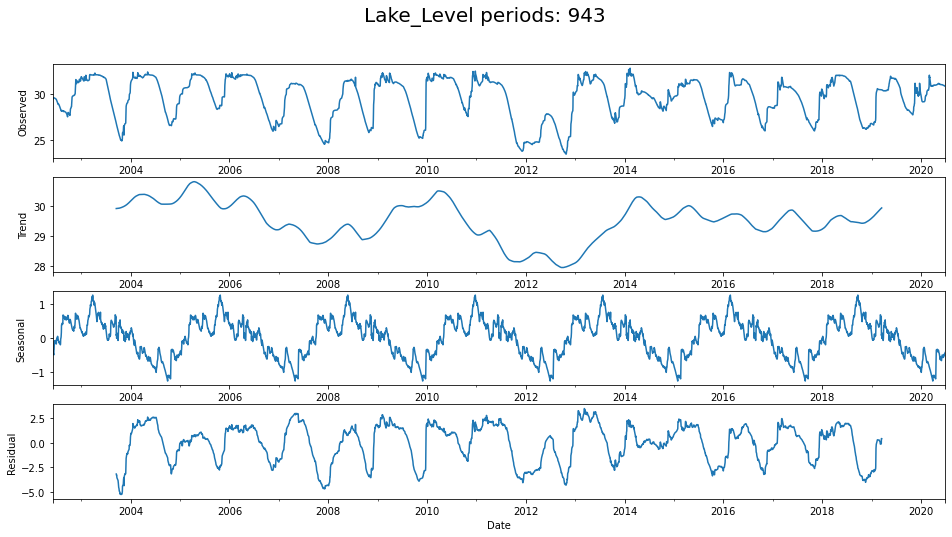

In [6]:
months = int(((max(df.index) - min(df.index))/np.timedelta64(1, 'M')))
weeks = int(((max(df.index) - min(df.index))/np.timedelta64(1, 'W')))

def seasonal_decompose_plot(series, period):
    
    result = seasonal_decompose(series, model='additive', period=period)

    fig, ax = plt.subplots(4,1, figsize=(16, 8))
    
    fig.suptitle('{} periods: {}'.format(series.name, period), size=20)

    result.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')
    result.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')
    result.seasonal.plot(ax=ax[2])
    ax[2].set_ylabel('Seasonal')
    result.resid.plot(ax=ax[3])
    ax[3].set_ylabel('Residual')
    
seasonal_decompose_plot(df['Lake_Level'], months)
seasonal_decompose_plot(df['Lake_Level'], weeks)

Dickey-Fuller Test for "Lake_Level":
	 ADF = -6.880991194599921
	   p = 1.4336336890483035e-09
	data IS stationary => p < 0.05 & adf < 1%


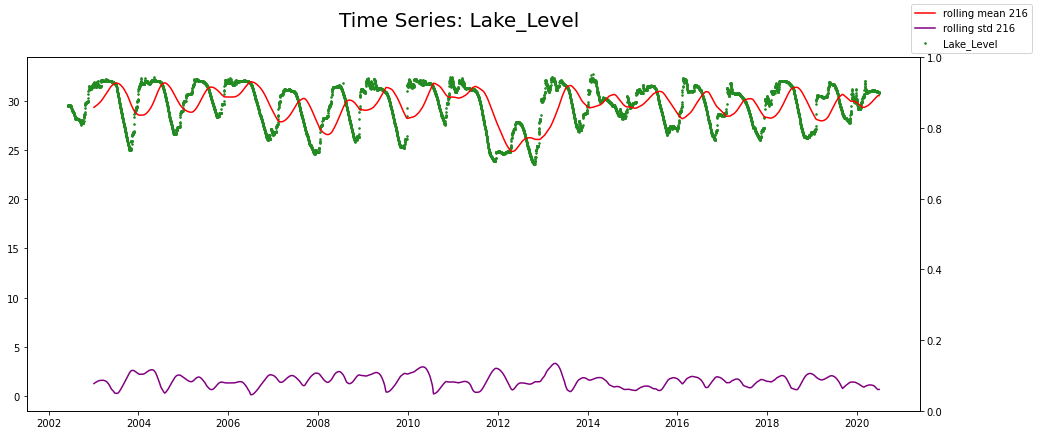

In [7]:
# STATIONARITY
# Stationarity check means that we have constant mean and variance of the data over the time.
# We can inspect visually or use Dickey-Fuller statistical test.

# Dickey-Fuller statisticall test:
# Is trying to reject the null hypothesis that the data is non-stationary.
# If we reject the test means that data is stationary
#    if p <= 0.05 we reject the null hypothesis and data is stationary
#    if p >  0.05 we accept the null hypothesis and data is non-stationary

def testDickeyFuller(series, rolling_interval):
    adf_test_result = sts.adfuller(series.values)
    
    significance_level = 0.05
    adf = adf_test_result[0]
    pValue = adf_test_result[1]
    threshold_1 = adf_test_result[4]['1%']
    threshold_5 = adf_test_result[4]['5%']
    threshold_10 = adf_test_result[4]['10%']
    
    print('Dickey-Fuller Test for "{}":'.format(series.name))
    print('\t ADF = {}'.format(str(adf)))
    print('\t   p = {}'.format(str(pValue)))
    
    color = 'purple'
    if (pValue < significance_level) & (adf < threshold_1):
        color = 'forestgreen' 
        print('\tdata IS stationary => p < {} & adf < 1%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_5):
        color = 'orange'
        print('\tdata IS stationary => p < {} & adf < 5%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_10):
        color = 'red'
        print('\tdata IS stationary => p < {} & adf < 10%'.format(significance_level))
    else:
        print('\tdata NOT stationary')
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 6.5))
    
    fig.suptitle('Time Series: {}'.format(series.name), size=20)
    
    ax.scatter(x=df.index, y=series, color=color, label=series.name, marker='.', s=10, alpha=1)
    ax2 = ax.twinx()

    ax.plot(series.rolling(rolling_interval).mean(), color='red', label='rolling mean {}'.format(rolling_interval))
    ax.plot(series.rolling(rolling_interval).std(), color='purple', label='rolling std {}'.format(rolling_interval))
    fig.legend()

testDickeyFuller(df['Lake_Level'], months)

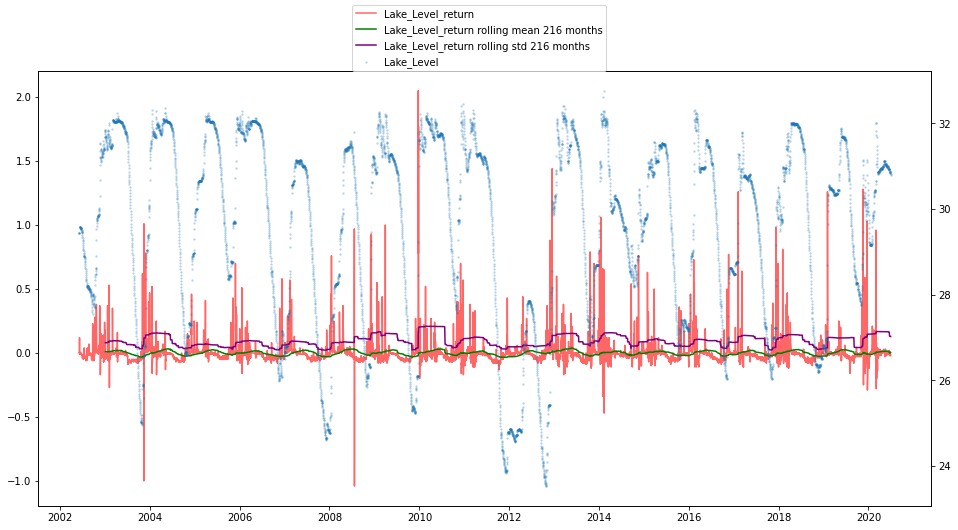

In [8]:
# Lake Level is stationary and this step is not needed

# df['Lake_Level_return'] = df['Lake_Level'].pct_change(1).mul(100)
df['Lake_Level_return'] = df['Lake_Level'].diff()
df = df.dropna()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(df['Lake_Level_return'], color='red', alpha=0.6, label='Lake_Level_return')
ax.plot(df['Lake_Level_return'].rolling(months).mean(), color='green', label='Lake_Level_return rolling mean {} months'.format(months))
ax.plot(df['Lake_Level_return'].rolling(months).std(), color='purple', label='Lake_Level_return rolling std {} months'.format(months))

ax2 = ax.twinx()
ax2.scatter(x=df.index, y=df['Lake_Level'], label='Lake_Level', marker='.', s=10, alpha=0.2)

fig.legend(loc='upper center')

Dickey-Fuller Test for "Lake_Level_return":
	 ADF = -10.865056104715213
	   p = 1.4143841746899893e-19
	data IS stationary => p < 0.05 & adf < 1%


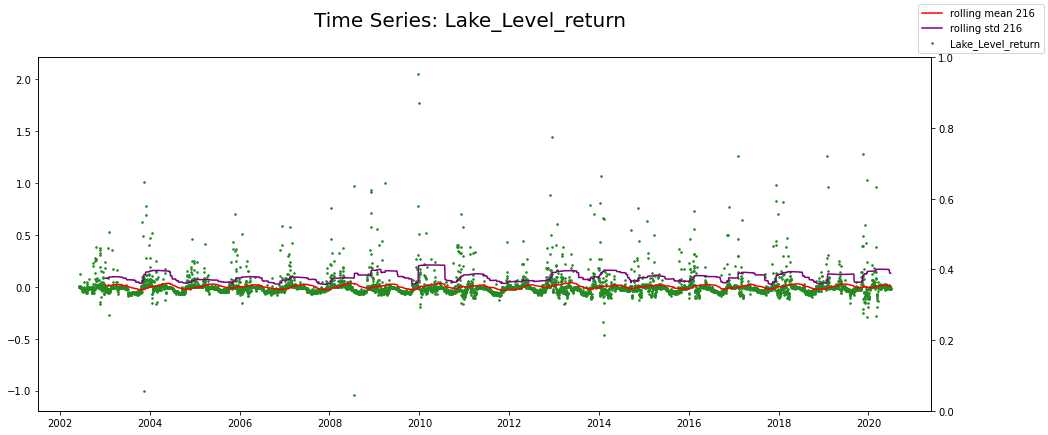

In [9]:
# Translating Lake_Level to % changes as expected did not change stationarity property

testDickeyFuller(df['Lake_Level_return'], months)

            Lake_Level  Lake_Level_return
Date                                     
2016-11-13       26.94               0.03
2016-11-14       26.96               0.02
2016-11-15       26.98               0.02
2016-11-16       26.98               0.00
2016-11-17       26.99               0.01
            Lake_Level  Lake_Level_return
Date                                     
2016-11-18       27.00               0.01
2016-11-19       27.50               0.50
2016-11-20       28.27               0.77
2016-11-21       28.39               0.12
2016-11-22       28.45               0.06


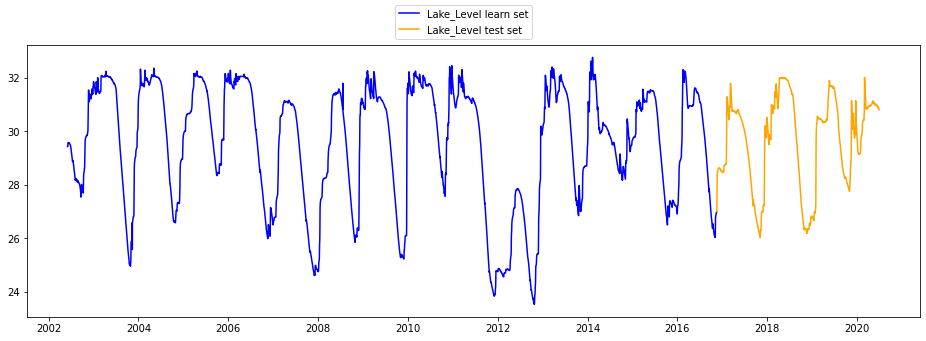

In [10]:
test_percentage = 0.2

split = int(len(df) * (1 - test_percentage))
df_learn = df.iloc[:split]
df_test = df.iloc[split:]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set')
fig.legend(loc='upper center');

print(df_learn.tail(5))
print(df_test.head(5))

/Users/klemenkozelj/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Lake_Level   No. Observations:                 5281
Model:                 ARIMA(4, 0, 4)   Log Likelihood                5222.542
Date:                Tue, 09 Feb 2021   AIC                         -10425.084
Time:                        13:43:55   BIC                         -10359.365
Sample:                    06-04-2002   HQIC                        -10402.114
                         - 11-17-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.5126      0.374     78.813      0.000      28.779      30.246
ar.L1          1.4597      0.114     12.819      0.000       1.236       1.683
ar.L2          0.1795      0.239      0.750      0.4

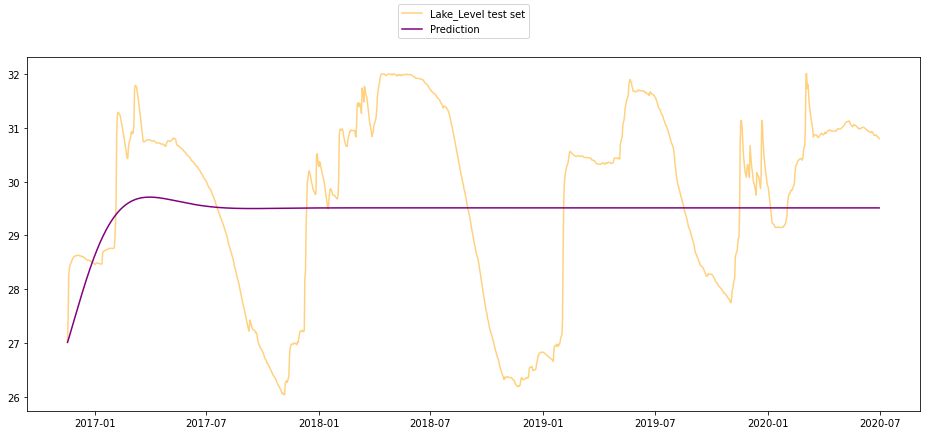

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA has P Q D parameters:
# P = number of autoregressive terms
# Q = number of nonseasonal differences (differencing order)
# D = number of moving-average terms (MA order)

model = ARIMA(df_learn['Lake_Level'], order=(4,0,4))
model_fit = model.fit()
print(model_fit.summary())

predictions = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])

fig, ax = plt.subplots(1, 1, figsize=(16, 6.5))

# ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set', alpha=0.5)
ax.plot(predictions, color='purple', label='Prediction')
fig.legend(loc='upper center');